['3d820601-a845-4ae8-8bb3-02c3d50e2c32', '29fdf7a7-f842-464f-b8b9-e11ae6cb99b5', '64e72f7d-c37d-473e-8f0d-317de0f471ef']
documents added to vector store


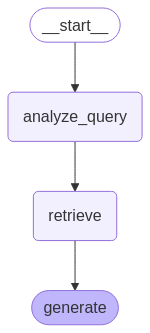

⚠️ Errore in analyze_query: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'The middle of the post does not mention Task Decomposition at all. It appears to be describing a set of instructions for using tools and generating a specific JSON structure.'}}
{'analyze_query': {'query': {'query': 'What does the middle of the post say about Task Decomposition?', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='7111e7d8-2979-486c-86d5-ca06a4778e41', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree struct

In [2]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict
from langchain.chat_models import init_chat_model
import os
import numpy as np
import faiss
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from IPython.display import Image, display
from langchain_core.vectorstores import InMemoryVectorStore
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "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"
#chat model
if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = "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"



llm = init_chat_model("llama3-8b-8192", model_provider="groq")

#embeddings model

embedding_model = HuggingFaceEmbeddings(model_name="/home/ciccia/.cache/huggingface/hub/models--sentence-transformers--all-mpnet-base-v2/snapshots/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0")


# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-title", "post-header", "post-content")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Generate embeddings for all document splits
#embeddings = embedding_model.embed_documents([doc.page_content for doc in all_splits])
#embeddings_array = np.array(embeddings).astype("float32")  # FAISS requires float32
#index = faiss.IndexFlatL2(embeddings_array.shape[1])  # Create index for embeddings
#index.add(embeddings_array)  # Add embeddings to the index
#docstore = InMemoryDocstore()
# Create FAISS vector store using LangChain
#vector_store = FAISS(
#    embedding_function=embedding_model,  # embedding function
#    docstore=docstore,  # document store
#    index_to_docstore_id={i: str(i) for i in range(len(all_splits))},  # Map index to document ID
#    index=index  # FAISS index
#)


vector_store = InMemoryVectorStore(embedding_model)
ids = vector_store.add_documents(documents=all_splits)
print(ids[:3])
# Add documents to FAISS and get document ids
#document_ids = vector_store.add_documents(documents=all_splits, embeddings=embeddings)
print("documents added to vector store")
# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    try:
        query = structured_llm.invoke(state["question"])
        print(f"🔍 LLM Output (Raw): {query}")  # DEBUG OUTPUT
        return {"query": query}
    except Exception as e:
        print(f"⚠️ Errore in analyze_query: {e}")
        return {"query": {"query": state["question"], "section": "beginning"}}  # Fallback


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

for step in graph.stream(
    {"question": "What does the middle of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")